***Contents*** 

&emsp; **1: Imports and Hyperparameter Initialization**

&emsp; **2: Datasets**

&emsp; **3: Architectures**

&emsp; &emsp; 3.1: LeNet Architecture

&emsp; &emsp; 3.2: LeNet Architecture with Dropout

&emsp; &emsp; 3.3: LeNet Architecture with Dropout and Batch Normalization

&emsp; **4: Training and Testing**

&emsp; &emsp; 4.1: Regular

&emsp; &emsp; 4.2: With Dropout

&emsp; &emsp; 4.3: With Dropout and Batch Norm

&emsp; **5: Write Up**

# Imports and Hyperparameter Initializaion

In [1]:
# Load in relevant libraries, and alias where appropriate
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import time

# Define relevant variables for the ML task
batch_size = 64
learning_rate = 0.01
num_epochs = 20

# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Datasets

In [2]:
# For training data
cifar_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())

# For test data
cifar_testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())


# DataLoader for training and test datasets
trainloader = torch.utils.data.DataLoader(cifar_trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(cifar_testset, batch_size=batch_size, shuffle=False)


# Architectures

## LeNet Architecture

|name|output size|
|---|---|
|Input|32x32x3|
|conv(kernel = 5, output channels = 6)|28x28x6|
|MaxPool(window = 2)|16x16x6|
|conv(kernel = 5, output channels = 16)|12x12x16|
|MaxPool(window = 2)|6x6x16|
|linear|120|
|linear|84|
|linear|10|


In [3]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.net = nn.Sequential(
            nn.LazyConv2d(out_channels=6, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.LazyConv2d(out_channels=16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Flatten(),

            nn.LazyLinear(out_features=120),
            nn.ReLU(),

            nn.LazyLinear(out_features=84),
            nn.ReLU(),

            nn.LazyLinear(out_features=10)
        )
        
    def forward(self, x):
        output = self.net(x)

        return output

## LeNet Architecture with Dropout

|name|output size|
|---|---|
|Input|32x32x3|
|conv(kernel = 5, output channels = 6)|28x28x6|
|MaxPool(window = 2)|16x16x6|
|conv(kernel = 5, output channels = 16)|12x12x16|
|MaxPool(window = 2)|6x6x16|
|linear|120|
|Dropout|120|
|linear|84|
|linear|10|


In [4]:
class LeNet_v1(nn.Module):
    def __init__(self, conv_dropout_rate = 0.2, fc_dropout_rate=0.5):
        super(LeNet_v1, self).__init__()
        self.net = nn.Sequential(
            nn.LazyConv2d(out_channels=6, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.LazyConv2d(out_channels=16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Flatten(),

            nn.LazyLinear(out_features=120),
            nn.ReLU(),

            nn.Dropout(fc_dropout_rate),

            nn.LazyLinear(out_features=84),
            nn.ReLU(),
            
            nn.LazyLinear(out_features=10)
        )

    def forward(self, x):
        output = self.net(x)
        return output

## LeNet Architecture with Dropout and Batch Normalization

|name|output size|
|---|---|
|Input|32x32x3|
|conv(kernel = 5, output channels = 6)|28x28x6|
|Batch Normalization|28x28x6|
|MaxPool(window = 2)|16x16x6|
|conv(kernel = 5, output channels = 16)|12x12x16|
|MaxPool(window = 2)|6x6x16|
|linear|120|
|Dropout|120|
|linear|84|
|linear|10|


In [5]:
class LeNet_v2(nn.Module):
    def __init__(self, fc_dropout_rate=0.5):
        super(LeNet_v2, self).__init__()
        self.net = nn.Sequential(
            nn.LazyConv2d(out_channels=6, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.LazyConv2d(out_channels=16, kernel_size=5),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Flatten(),

            nn.LazyLinear(out_features=120),
            nn.ReLU(),

            nn.Dropout(fc_dropout_rate),

            nn.LazyLinear(out_features=84),
            nn.ReLU(),

            nn.LazyLinear(out_features=10)
        )

    def forward(self, x):
        output = self.net(x)
        return output

# Training and Testing

**Train and Test Functions**

In [6]:
def train(model, trainloader, num_epochs=num_epochs):
    start_time = time.time()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    
    # Lists to store losses for plotting
    epoch_losses = []
    
    # Training loop
    for epoch in range(num_epochs):
        # Set model to training mode
        model.train()
        
        running_loss = 0.0
        batches_in_epoch = 0
        
        for i, (inputs, labels) in enumerate(trainloader):
            # Move data to device (CPU/GPU)
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Accumulate statistics
            running_loss += loss.item()
            batches_in_epoch += 1
        
        # Store average loss for this epoch
        avg_epoch_loss = running_loss / batches_in_epoch
        epoch_losses.append(avg_epoch_loss)
        print(f'Epoch {epoch + 1}, Loss: {avg_epoch_loss:.3f}')
    
    # Plot the training loss
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o')
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Training completed in {elapsed_time:.2f} seconds")
    
    # return epoch_losses

def test(model, testloader):
    start_time = time.time()
    # Testing the best model on test data
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f'testing finished in {elapsed_time:.2f} seconds, Accuracy: {accuracy:.2f}%')

## Regular

Epoch 1, Loss: 2.056
Epoch 2, Loss: 1.622
Epoch 3, Loss: 1.465
Epoch 4, Loss: 1.363
Epoch 5, Loss: 1.283
Epoch 6, Loss: 1.207
Epoch 7, Loss: 1.152
Epoch 8, Loss: 1.095
Epoch 9, Loss: 1.046
Epoch 10, Loss: 1.005
Epoch 11, Loss: 0.967
Epoch 12, Loss: 0.939
Epoch 13, Loss: 0.904
Epoch 14, Loss: 0.877
Epoch 15, Loss: 0.851
Epoch 16, Loss: 0.829
Epoch 17, Loss: 0.812
Epoch 18, Loss: 0.777
Epoch 19, Loss: 0.757
Epoch 20, Loss: 0.743


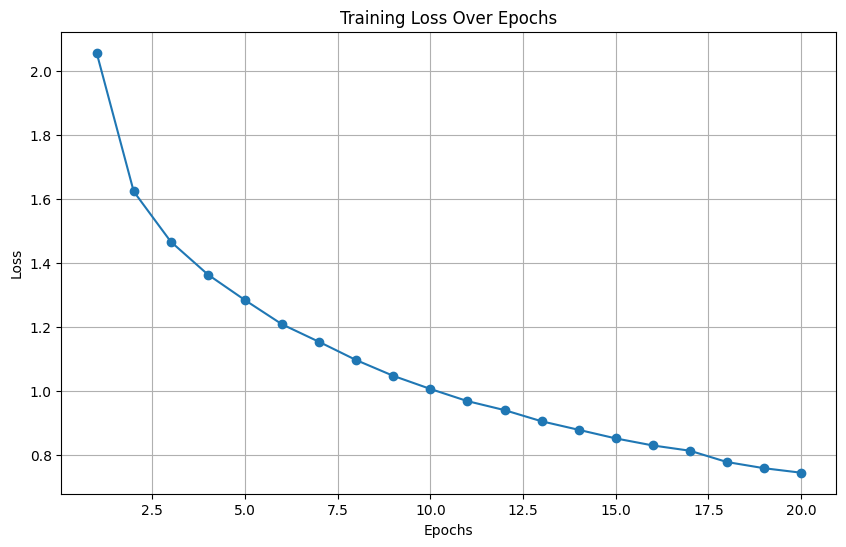

Training completed in 73.68 seconds


In [7]:
model = LeNet().to(device)
train(model, trainloader)

In [8]:
test(model, testloader)

testing finished in 0.60 seconds, Accuracy: 58.43%


## With Dropout

Epoch 1, Loss: 2.101
Epoch 2, Loss: 1.714
Epoch 3, Loss: 1.529
Epoch 4, Loss: 1.446
Epoch 5, Loss: 1.392
Epoch 6, Loss: 1.347
Epoch 7, Loss: 1.315
Epoch 8, Loss: 1.288
Epoch 9, Loss: 1.267
Epoch 10, Loss: 1.242
Epoch 11, Loss: 1.225
Epoch 12, Loss: 1.204
Epoch 13, Loss: 1.193
Epoch 14, Loss: 1.174
Epoch 15, Loss: 1.164
Epoch 16, Loss: 1.157
Epoch 17, Loss: 1.149
Epoch 18, Loss: 1.132
Epoch 19, Loss: 1.126
Epoch 20, Loss: 1.110


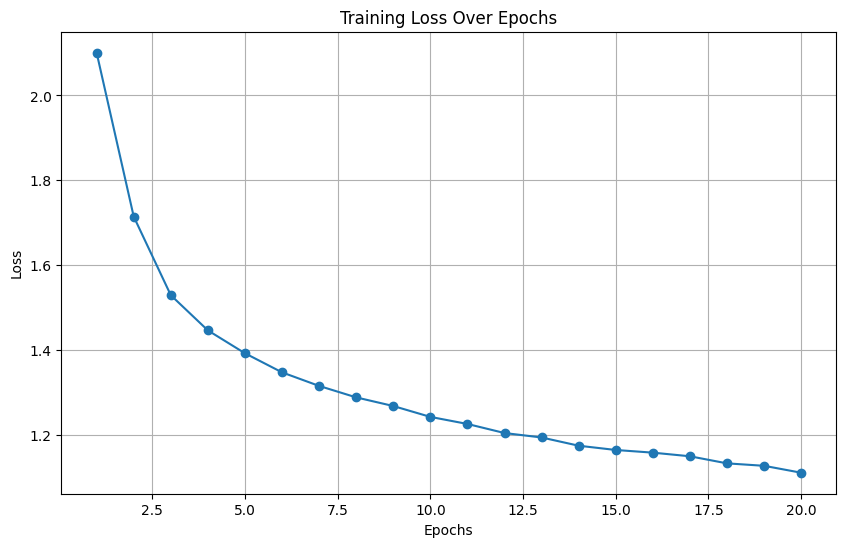

Training completed in 73.45 seconds


In [9]:
model1 = LeNet_v1().to(device)
train(model1, trainloader)

In [10]:
test(model1, testloader)

testing finished in 0.57 seconds, Accuracy: 60.91%


## With Dropout and Batch Norm

Epoch 1, Loss: 1.775
Epoch 2, Loss: 1.545
Epoch 3, Loss: 1.437
Epoch 4, Loss: 1.369
Epoch 5, Loss: 1.318
Epoch 6, Loss: 1.282
Epoch 7, Loss: 1.254
Epoch 8, Loss: 1.234
Epoch 9, Loss: 1.212
Epoch 10, Loss: 1.187
Epoch 11, Loss: 1.173
Epoch 12, Loss: 1.160
Epoch 13, Loss: 1.146
Epoch 14, Loss: 1.139
Epoch 15, Loss: 1.124
Epoch 16, Loss: 1.106
Epoch 17, Loss: 1.106
Epoch 18, Loss: 1.095
Epoch 19, Loss: 1.087
Epoch 20, Loss: 1.082


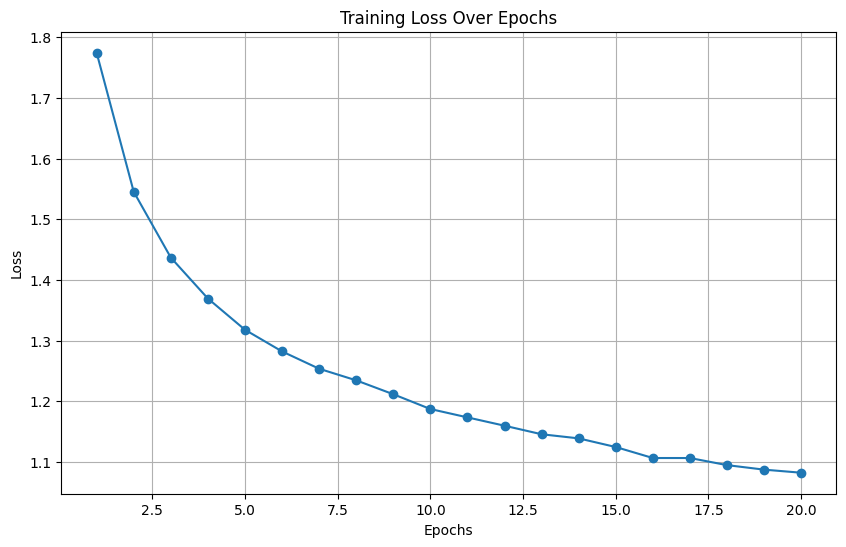

Training completed in 74.90 seconds


In [11]:
model2 = LeNet_v2().to(device)
train(model2, trainloader)

In [12]:
test(model2, testloader)

testing finished in 0.59 seconds, Accuracy: 61.33%


# Write Up

<!-- ## Design Descisions
### Hyperparameters
#### Batch Size
I used a batch size of 64, as it gave me better performance than 128, 256. The smaller batch size allowed for more frequent weight updates, which helped the model navigate the loss landscape more effectively. While larger batches could potentially use GPU resources more efficiently, the 64 batch size struck the right balance between computational efficiency and learning dynamics for this CIFAR-10 classification task, with a total train time of ~67 seconds per model
#### Epochs
I chose number of epochs as 20 because 10 was not converging well enough at first. I then made some changes but I never tried back to 10. Maybe it works but this is doing a good job and I dont want to touch it.
#### Learning Rate
I tried 0.0001 but that converged too slow, and more than 20 epochs was just not economical for the sake of a homework. so I tried 0.01 which did a good job.
### Layer Choices
I used LazyLinear as it does the input calculations for me. to my understanding I dont see any drawbacks of doing this at for the sake of a simple arch like LeNet-5
### Activations
I used ReLU for everything because ReLU Rocks and I see no particular drawbacks here yet
### Optimization Functions
I used SGD with Momentum with momentum at 0.9. this is useful as it avoids any problems wiht local minimas

## Modification Steps
### Dropout Layer
Adding dropout to the LeNet architecture shows significant improvement in preventing overfitting:
- Acts as a regularization technique by randomly "dropping" neurons during training
- Forces the network to learn more robust features that don't rely on specific neurons
- Creates an implicit ensemble effect, as each training iteration uses a different subset of neurons

### Dropout + Batch Normalization layers
Combining dropout with batch normalization further enhances model performance:
- Batch normalization stabilizes the learning process by normalizing layer inputs
- Reduces internal covariate shift, allowing for higher learning rates
- Works synergistically with dropout to improve both training speed and generalization
- Helps mitigate vanishing/exploding gradient problems in deeper networks

## The Final Word
These did not improve the accuracy too much (60 &rarr; 65), but a win is a win -->

## Design Decisions
### Hyperparameter Selection
#### Batch Size
I selected a batch size of 64 after experimenting with larger sizes (128, 256). The smaller batch size provided better performance by allowing more frequent weight updates, helping the model navigate the loss landscape more effectively. While larger batches could theoretically use GPU resources more efficiently, 64 struck the right balance between computational efficiency and learning effectiveness for this CIFAR-10 task. Total training time was approximately 67 seconds per model.

#### Epochs
I settled on 20 epochs for training after finding that 10 epochs wasn't enough for proper convergence in initial tests. After making architectural improvements, I stuck with 20 epochs since the model was performing well, though fewer might have been sufficient.

#### Learning Rate
Initially, I tried 0.0001, but this converged too slowly and would have required many more epochs to reach good performance. Increasing to 0.01 provided much better convergence within my 20-epoch constraint.

### Architecture Decisions

#### Layer Implementation
I utilized LazyLinear layers since they automatically handle input size calculations. For a straightforward architecture like LeNet-5, this simplified implementation without any noticeable drawbacks.

#### Activation Functions
ReLU was implemented throughout the network due to its computational efficiency and effectiveness in preventing vanishing gradient problems common in deeper networks.

#### Optimization Approach
I chose SGD with a momentum value of 0.9, which helps overcome local minima and generally provides faster convergence than standard SGD by accumulating movement in consistent directions.

## Model Improvements
The improvements were tested with the same dataset loaders to have a proper point of comparison.

### Dropout Implementation
Adding dropout layers significantly helped prevent overfitting by:
- Randomly deactivating neurons during training, forcing the network to be less dependent on specific features
- Creating an implicit ensemble effect, as each training batch effectively uses a slightly different network
- Improving generalization to unseen data

### Batch Normalization Addition
Combining dropout with batch normalization further enhanced performance by:
- Normalizing inputs to each layer, which stabilizes and accelerates the training process
- Reducing internal covariate shift, allowing higher learning rates without divergence
- Working well alongside dropout to create a more robust training procedure

## Results
These modifications improved accuracy from around ~58% to ~62%. While this may seem very little, a win is a win.
